In [1]:
import numpy as np
import tensorflow as tf
import os

from scipy.misc import imread, imresize
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import vgg16_2D

In [4]:
# Path for tf.summary.FileWriter and to store model checkpoints
filewriter_path = "/home/hngu4068/Documents/vgg/adam"
checkpoint_path = "/home/hngu4068/Documents/vgg/checkpoint"

In [5]:
learning_rate = 1e-4
num_epochs = 1
batch_size = 10
num_classes = 2
dropout_rate = 0.5
display_step = 1
val_batches_per_epoch = 2
train_batches_per_epoch = int(380/batch_size)

In [6]:
# List of trainable variables of the layers we want to train
imgs = tf.placeholder(tf.float32, [None,224,224, 3])
y = tf.placeholder(tf.float32, [None, num_classes])
train_layers = ['fc8','fc7','fc6','conv5_1','conv5_2','conv5_3']
keep_prob = tf.placeholder(tf.float32)

vgg_2d = vgg16_2D.vgg16(imgs,keep_prob,num_classes,train_layers)
score = vgg_2d.probs

In [7]:
# Op for calculating the loss
var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]

with tf.name_scope("cross_ent"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = score, labels = y))
# Train op
with tf.name_scope("train"):
    # Get gradients of all trainable variables
    gradients = tf.gradients(loss, var_list)
    gradients = list(zip(gradients, var_list))

    # Create optimizer and apply gradient descent to the trainable variables
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.apply_gradients(grads_and_vars=gradients)

# Add gradients to summary
for gradient, var in gradients:
    tf.summary.histogram(var.name + '/gradient', gradient)

# Add the variables we train to the summary
for var in var_list:
    tf.summary.histogram(var.name, var)

# Add the loss to summary
tf.summary.scalar('cross_entropy', loss)

# Evaluation op: Accuracy of the model
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add the accuracy to the summary
tf.summary.scalar('accuracy', accuracy)


#Merge all summaries together
merged_summary = tf.summary.merge_all()

# Initialize the FileWriter
writer = tf.summary.FileWriter(filewriter_path)

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

INFO:tensorflow:Summary name fc6/weights:0/gradient is illegal; using fc6/weights_0/gradient instead.
INFO:tensorflow:Summary name fc6/biases:0/gradient is illegal; using fc6/biases_0/gradient instead.
INFO:tensorflow:Summary name fc7/weights:0/gradient is illegal; using fc7/weights_0/gradient instead.
INFO:tensorflow:Summary name fc7/biases:0/gradient is illegal; using fc7/biases_0/gradient instead.
INFO:tensorflow:Summary name fc8/weights:0/gradient is illegal; using fc8/weights_0/gradient instead.
INFO:tensorflow:Summary name fc8/biases:0/gradient is illegal; using fc8/biases_0/gradient instead.
INFO:tensorflow:Summary name fc6/weights:0 is illegal; using fc6/weights_0 instead.
INFO:tensorflow:Summary name fc6/biases:0 is illegal; using fc6/biases_0 instead.
INFO:tensorflow:Summary name fc7/weights:0 is illegal; using fc7/weights_0 instead.
INFO:tensorflow:Summary name fc7/biases:0 is illegal; using fc7/biases_0 instead.
INFO:tensorflow:Summary name fc8/weights:0 is illegal; using f

In [8]:
def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'image': tf.FixedLenFeature([224*224], tf.float32),
            'label': tf.FixedLenFeature([2], tf.int64)
        })
    # now return the converted data
    image = features['image']
    label = features['label']
    return image,label

In [9]:
# returns symbolic label and image
image,label = read_and_decode_single_example("oasis_train_2d_slice.tfrecords")

# groups examples into batches randomly
images_batch,labels_batch = tf.train.shuffle_batch(
    [image,label], batch_size=batch_size,
    capacity=batch_size*4,
    min_after_dequeue=batch_size*2)
    
# returns symbolic label and image
image_test,label_test = read_and_decode_single_example("oasis_test_2d_slice.tfrecords")

# groups examples into batches randomly
images_test_batch,labels_test_batch = tf.train.shuffle_batch(
    [image_test,label_test], batch_size=20,
    capacity=80,
    min_after_dequeue=20)

In [10]:
# Start Tensorflow session
with tf.Session() as sess:

    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)

    # Load the pretrained weights into the non-trainable layer
    vgg_2d.load_weights('vgg16.npy',sess)
    
    # Get a batch of images and labels
    batch_xs, batch_ys = sess.run([images_batch,labels_batch])
    batch_xs = np.tile(np.reshape(batch_xs,[-1,224,224,1]),3)
    
    temp = sess.run(tf.nn.softmax_cross_entropy_with_logits(logits = score, labels = y), feed_dict={imgs: batch_xs,
                                          y: batch_ys,
                                          keep_prob: 1.})
    coord.request_stop()
    coord.join(threads)

In [11]:
# Start Tensorflow session
with tf.Session() as sess:

    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)

    # Load the pretrained weights into the non-trainable layer
    vgg_2d.load_weights('vgg16.npy',sess)

    print("{} Start training...".format(datetime.now()))
    print("{} Open Tensorboard at --logdir {}".format(datetime.now(),
                                                filewriter_path))
    
    temp_score = []
    # Loop over number of epochs
    for epoch in range(num_epochs):

        print("{} Epoch number: {}".format(datetime.now(), epoch+1))

        step = 1
        
        
        while step < 3:
            print("we are at step %d" %step)
            # Get a batch of images and labels
            batch_xs, batch_ys = sess.run([images_batch,labels_batch])

            batch_xs = np.tile(np.reshape(batch_xs,[-1,224,224,1]),3)
            # And run the training op
            sess.run(train_op, feed_dict={imgs: batch_xs,
                                          y: batch_ys,
                                          keep_prob: dropout_rate})
            
            temp1,temp2,temp3,temp4 = sess.run([vgg_2d.pool1,vgg_2d.pool2,vgg_2d.pool3,vgg_2d.pool4], feed_dict={imgs: batch_xs,
                                          y: batch_ys,
                                          keep_prob: dropout_rate})
            temp_score.append(sess.run(loss, feed_dict={imgs: batch_xs,
                                          y: batch_ys,
                                          keep_prob: dropout_rate}))

            # Generate summary with the current batch of data and write to file
            if step%display_step == 0:
                s = sess.run(merged_summary, feed_dict={imgs: batch_xs,
                                                        y: batch_ys,
                                                        keep_prob: 1.})
                writer.add_summary(s, epoch*train_batches_per_epoch + step)

            step += 1

        # Validate the model on the entire validation set
        print("{} Start validation".format(datetime.now()))
        test_acc = 0.
        test_count = 0
        for _ in range(val_batches_per_epoch):
            batch_tx, batch_ty = sess.run([images_test_batch,labels_test_batch])
            batch_tx = np.tile(np.reshape(batch_tx,[-1,224,224,1]),3)
            acc = sess.run(accuracy, feed_dict={imgs: batch_tx,
                                                y: batch_ty,
                                                keep_prob: 1.})
            test_acc += acc
            test_count += 1
        test_acc /= test_count
        
        print("{} Saving checkpoint of model...".format(datetime.now()))

        #save checkpoint of the model
        checkpoint_name = os.path.join(checkpoint_path, 'model_epoch'+str(epoch)+'.ckpt')
        save_path = saver.save(sess, checkpoint_name)

        print("{} Model checkpoint saved at {}".format(datetime.now(), checkpoint_name))
        
    coord.request_stop()
    coord.join(threads)

2017-05-16 15:30:21.431186 Start training...
2017-05-16 15:30:21.431280 Open Tensorboard at --logdir /home/hngu4068/Documents/vgg/adam
2017-05-16 15:30:21.431307 Epoch number: 1
we are at step 1
we are at step 2
2017-05-16 15:30:51.938087 Start validation
2017-05-16 15:31:05.782745 Saving checkpoint of model...
2017-05-16 15:31:19.534964 Model checkpoint saved at /home/hngu4068/Documents/vgg/checkpoint/model_epoch0.ckpt


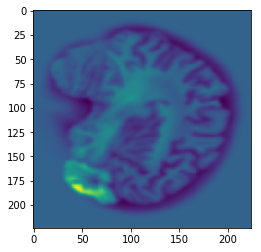

In [16]:
plt.imshow(batch_xs[5,:,:,1])

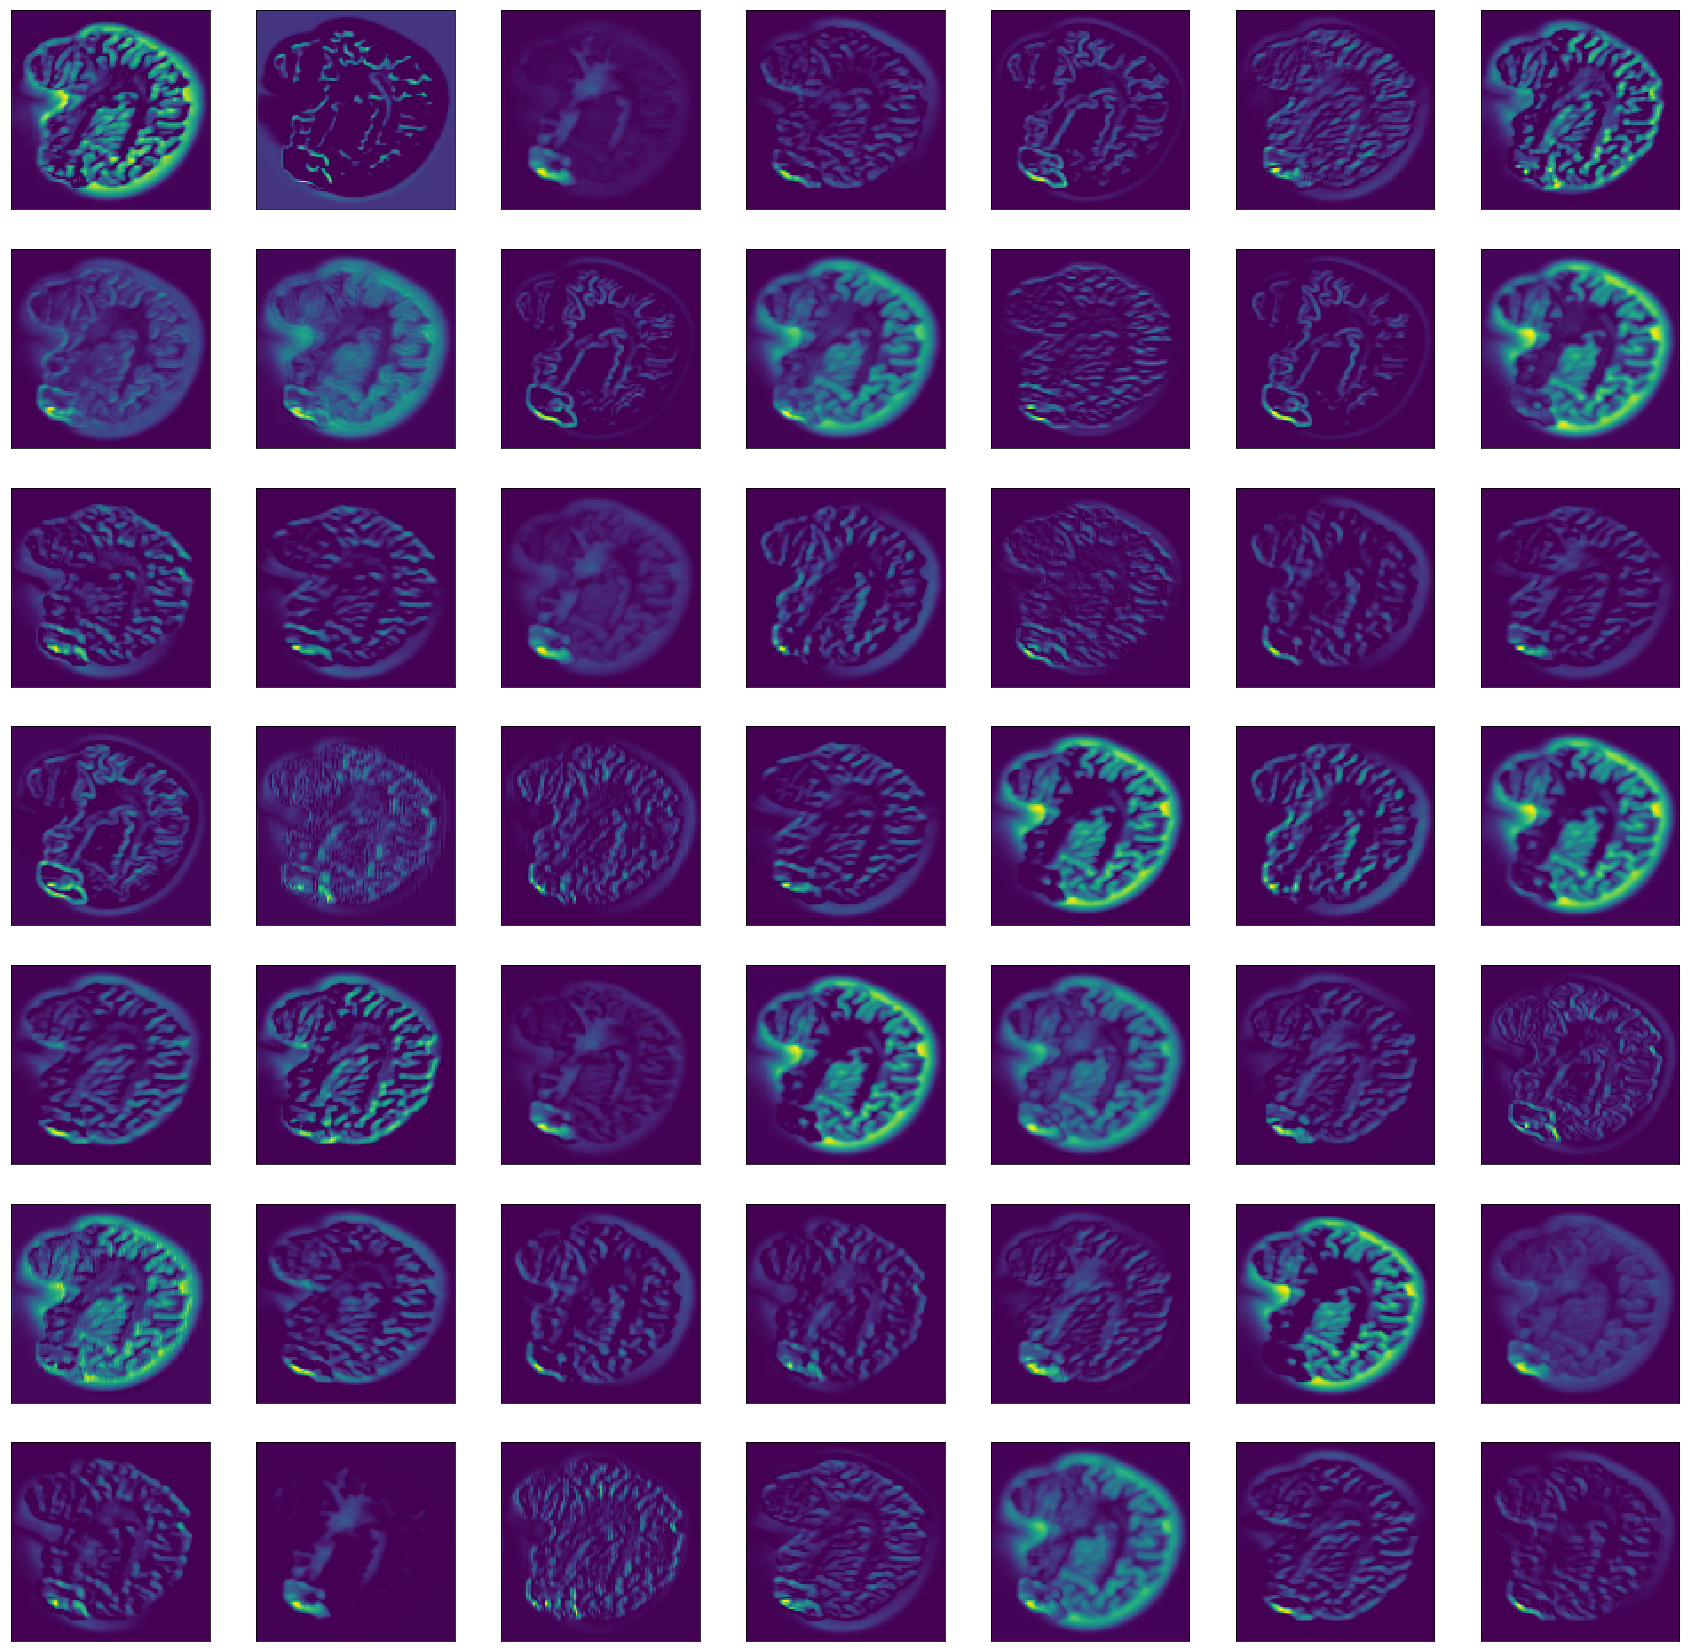

In [12]:
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(30,30))
for ax in axes.flat:
    # Hide all ticks and labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')
        
# Plot the data.
z = 0
for i, j in zip(*np.triu_indices_from(axes, k=0)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].imshow(temp1[5,:,:,z])
        z+=1

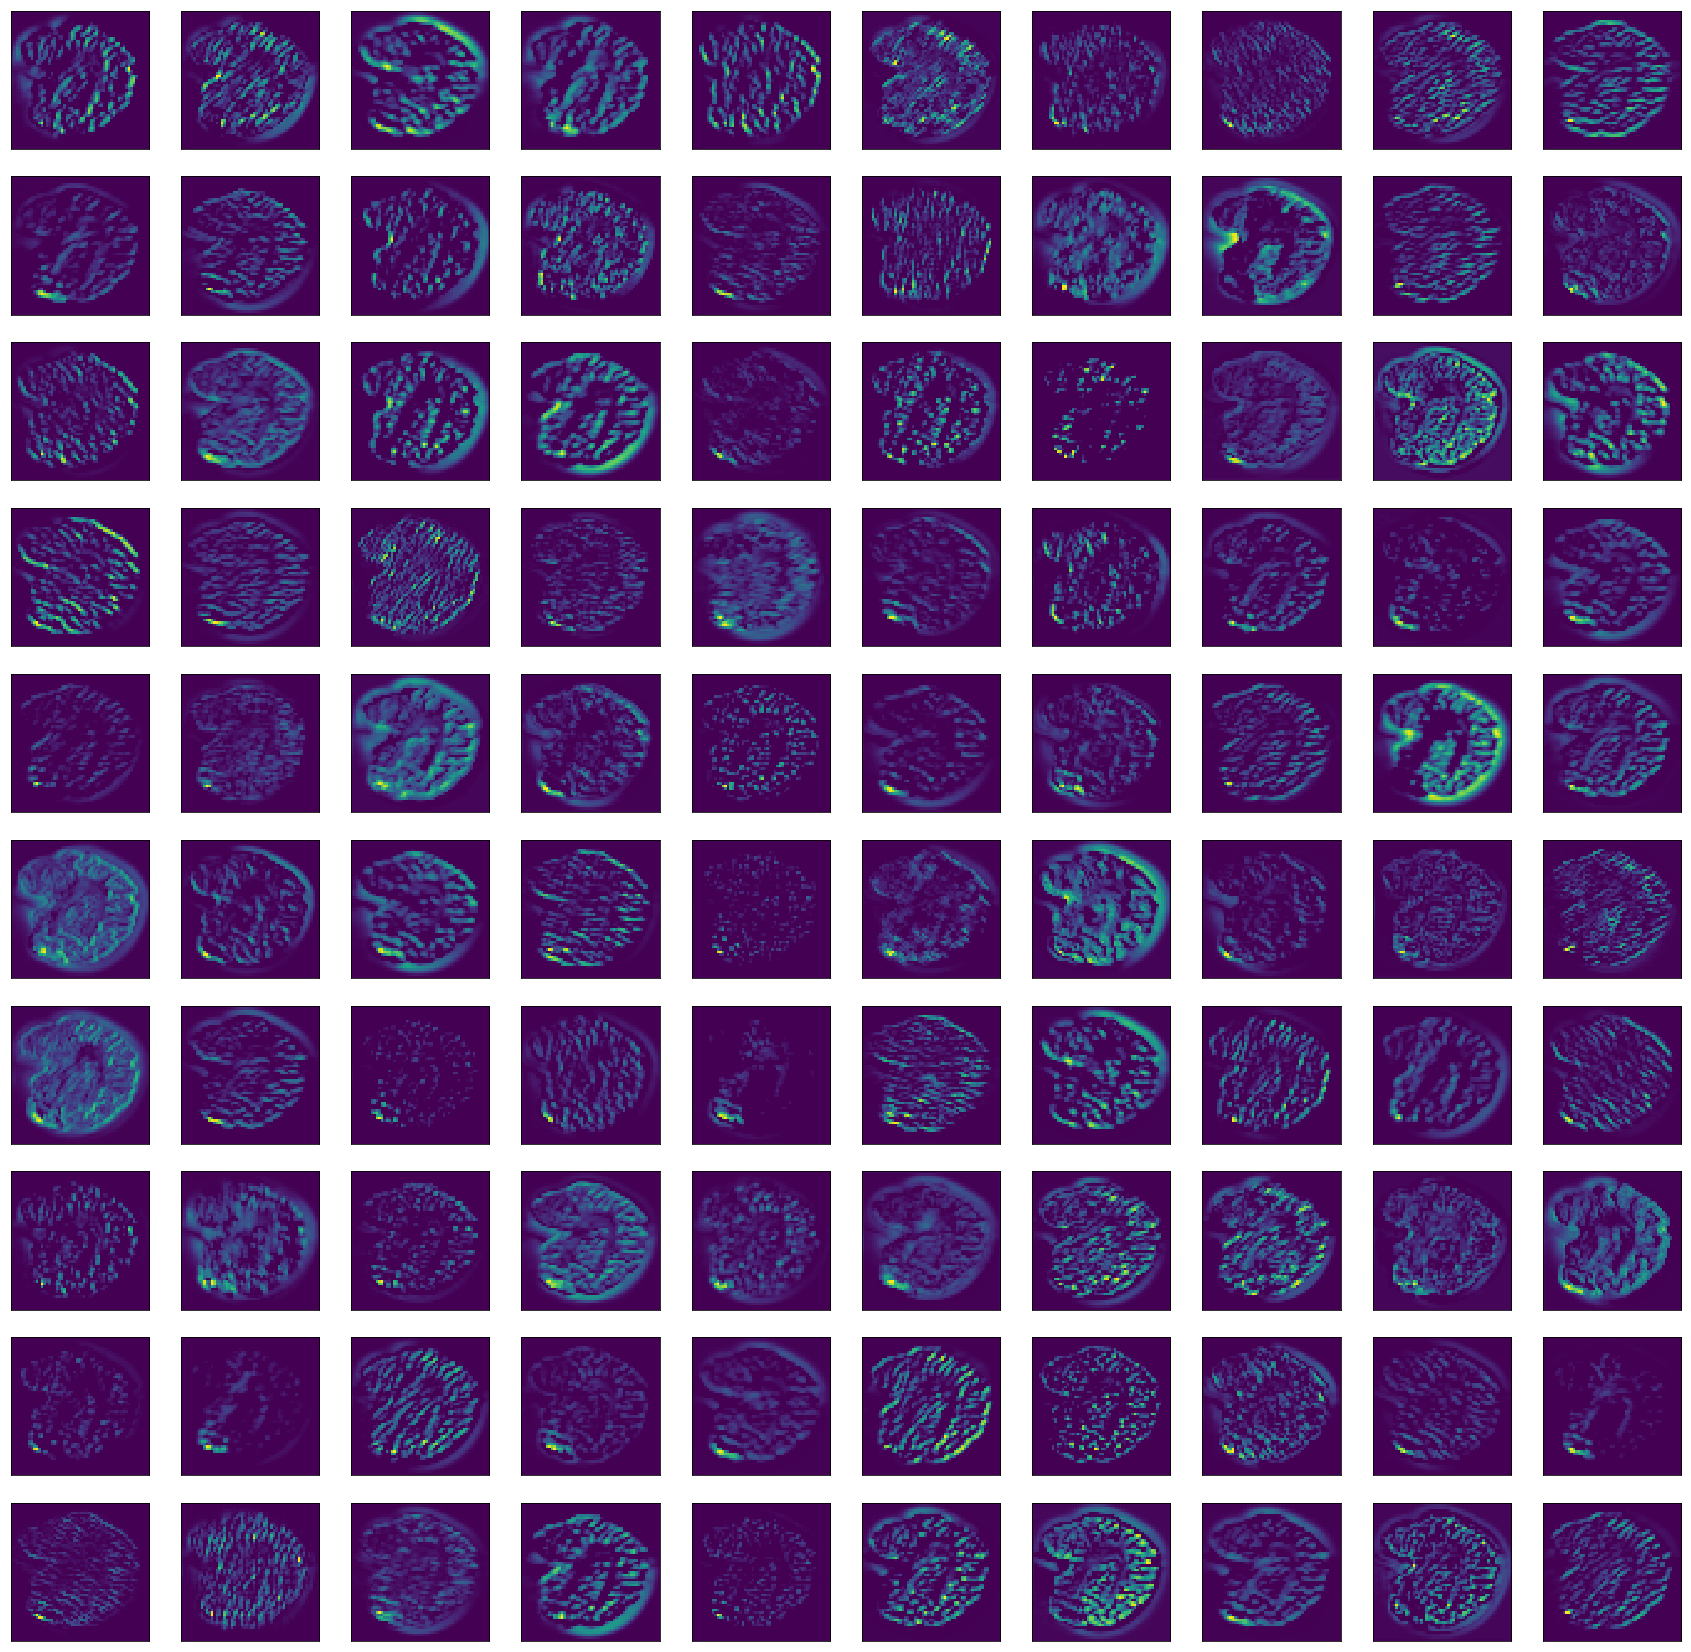

In [13]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(30,30))
for ax in axes.flat:
    # Hide all ticks and labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')
        
# Plot the data.
z = 0
for i, j in zip(*np.triu_indices_from(axes, k=0)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].imshow(temp2[5,:,:,z])
        z+=1

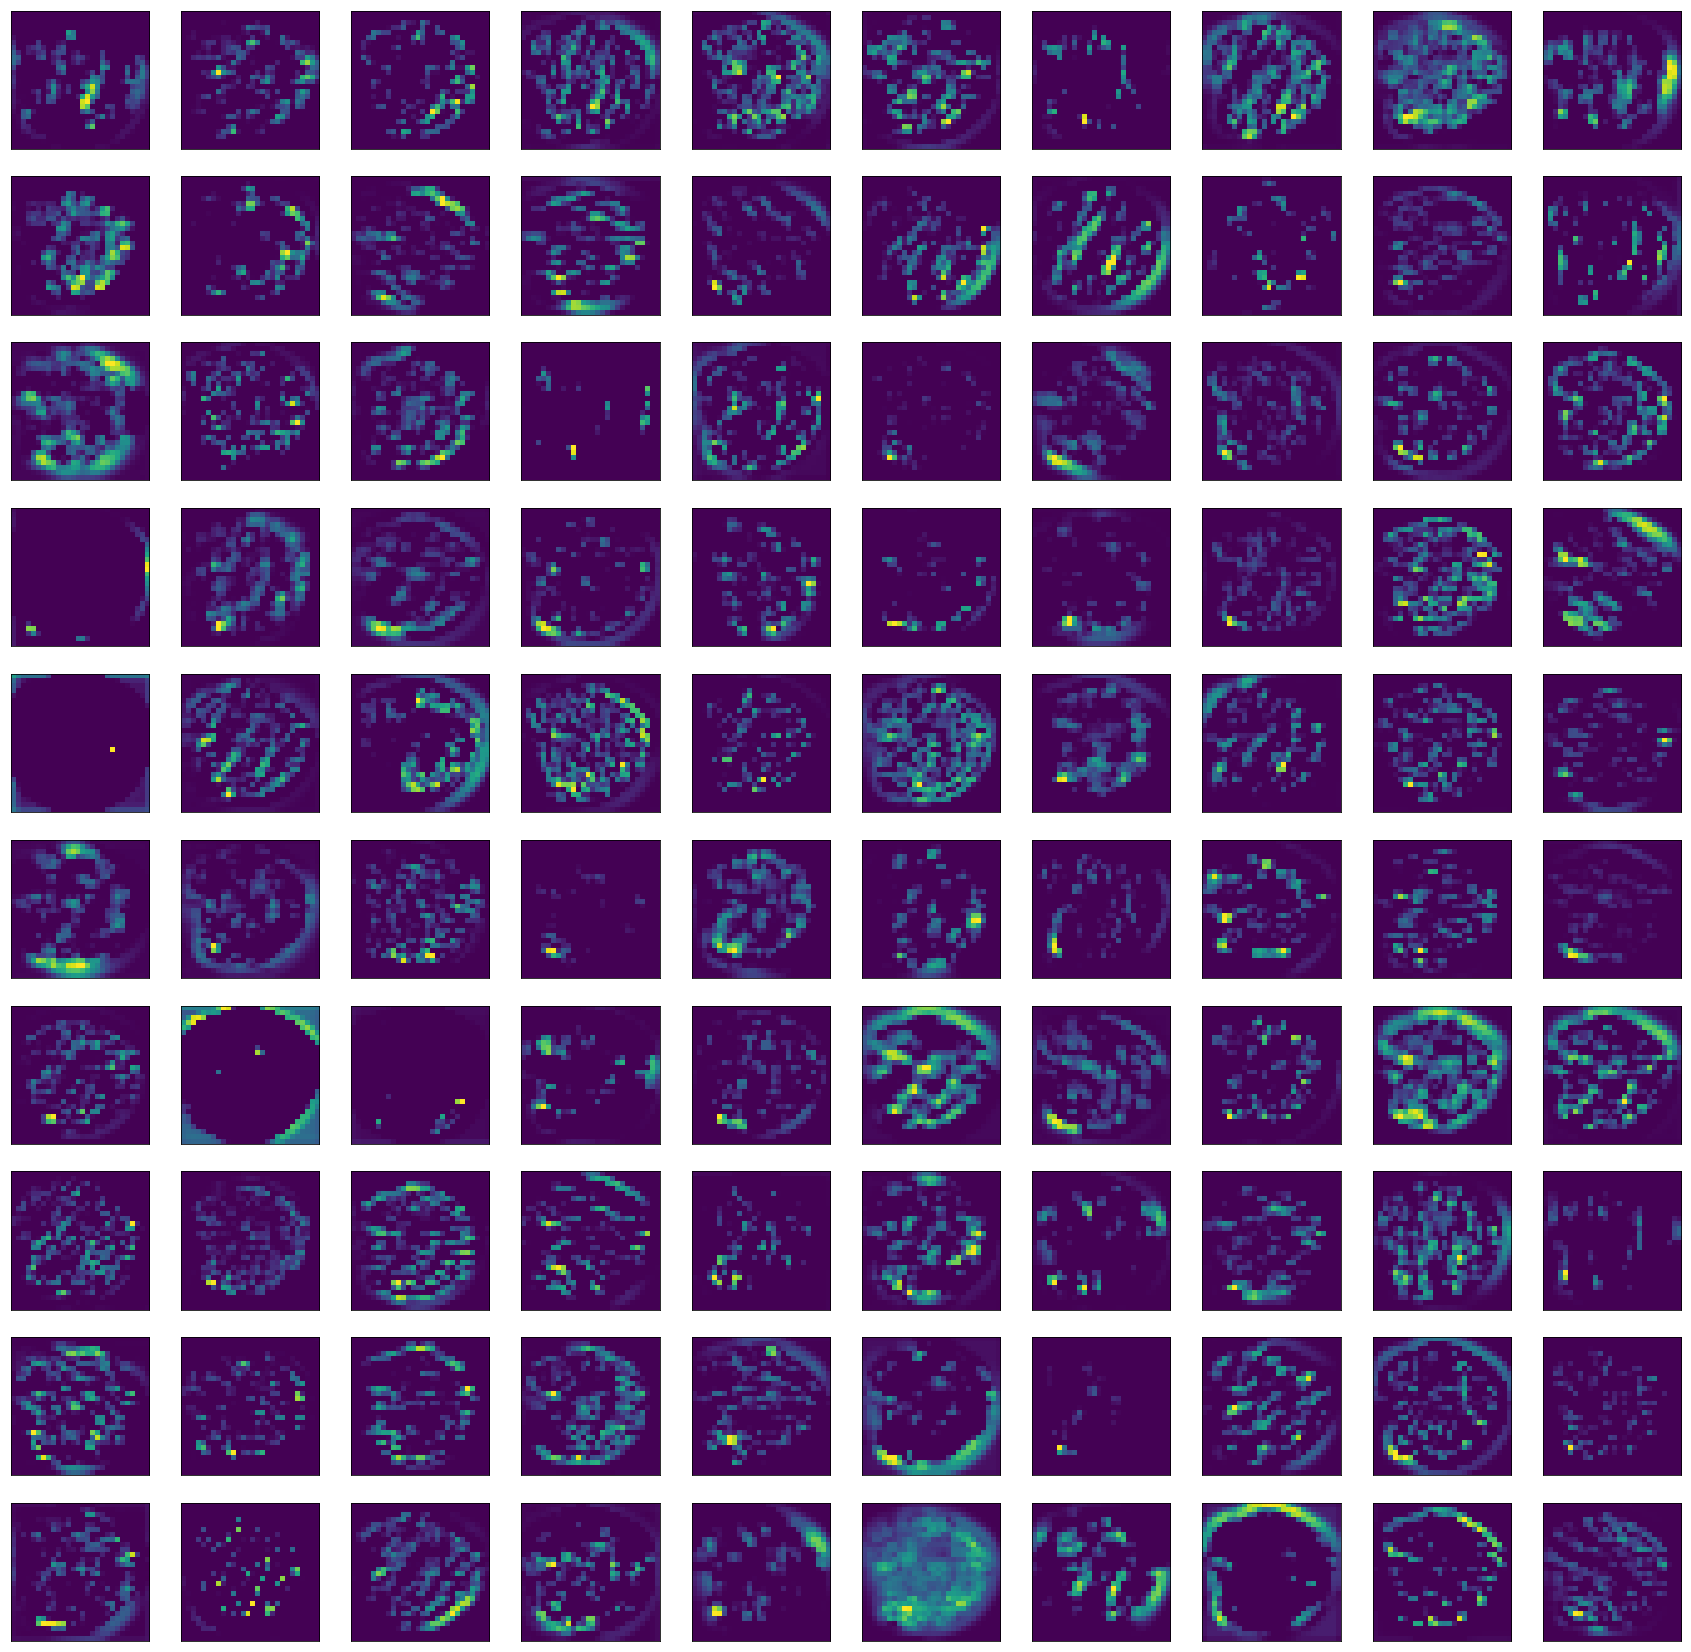

In [14]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(30,30))
for ax in axes.flat:
    # Hide all ticks and labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')
        
# Plot the data.
z = 0
for i, j in zip(*np.triu_indices_from(axes, k=0)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].imshow(temp3[5,:,:,z])
        z+=1

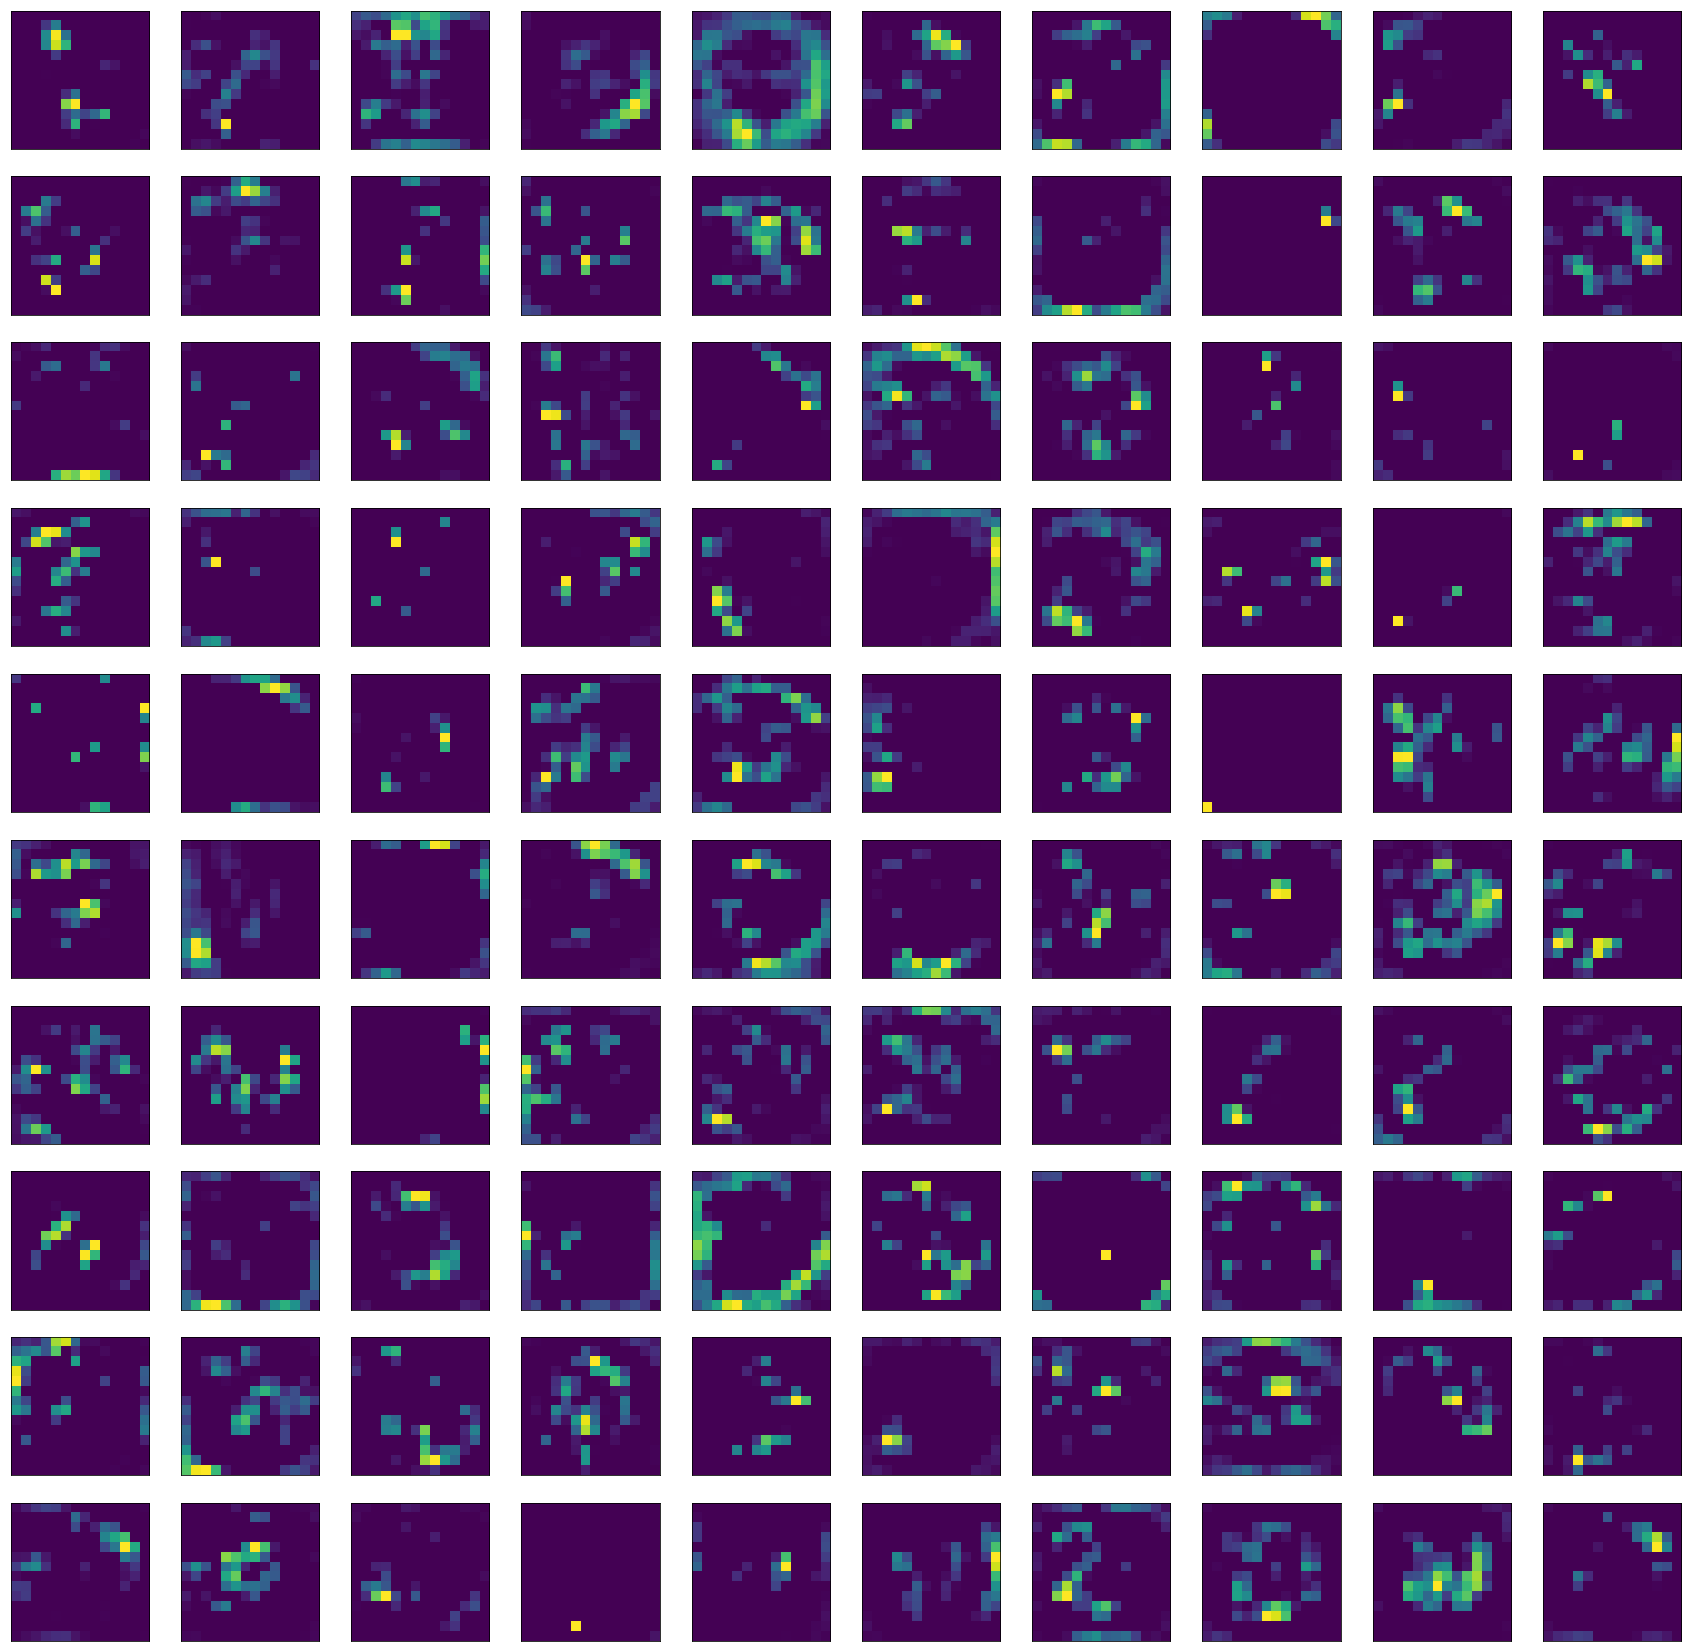

In [15]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(30,30))
for ax in axes.flat:
    # Hide all ticks and labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')
        
# Plot the data.
z = 0
for i, j in zip(*np.triu_indices_from(axes, k=0)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].imshow(temp4[5,:,:,z])
        z+=1

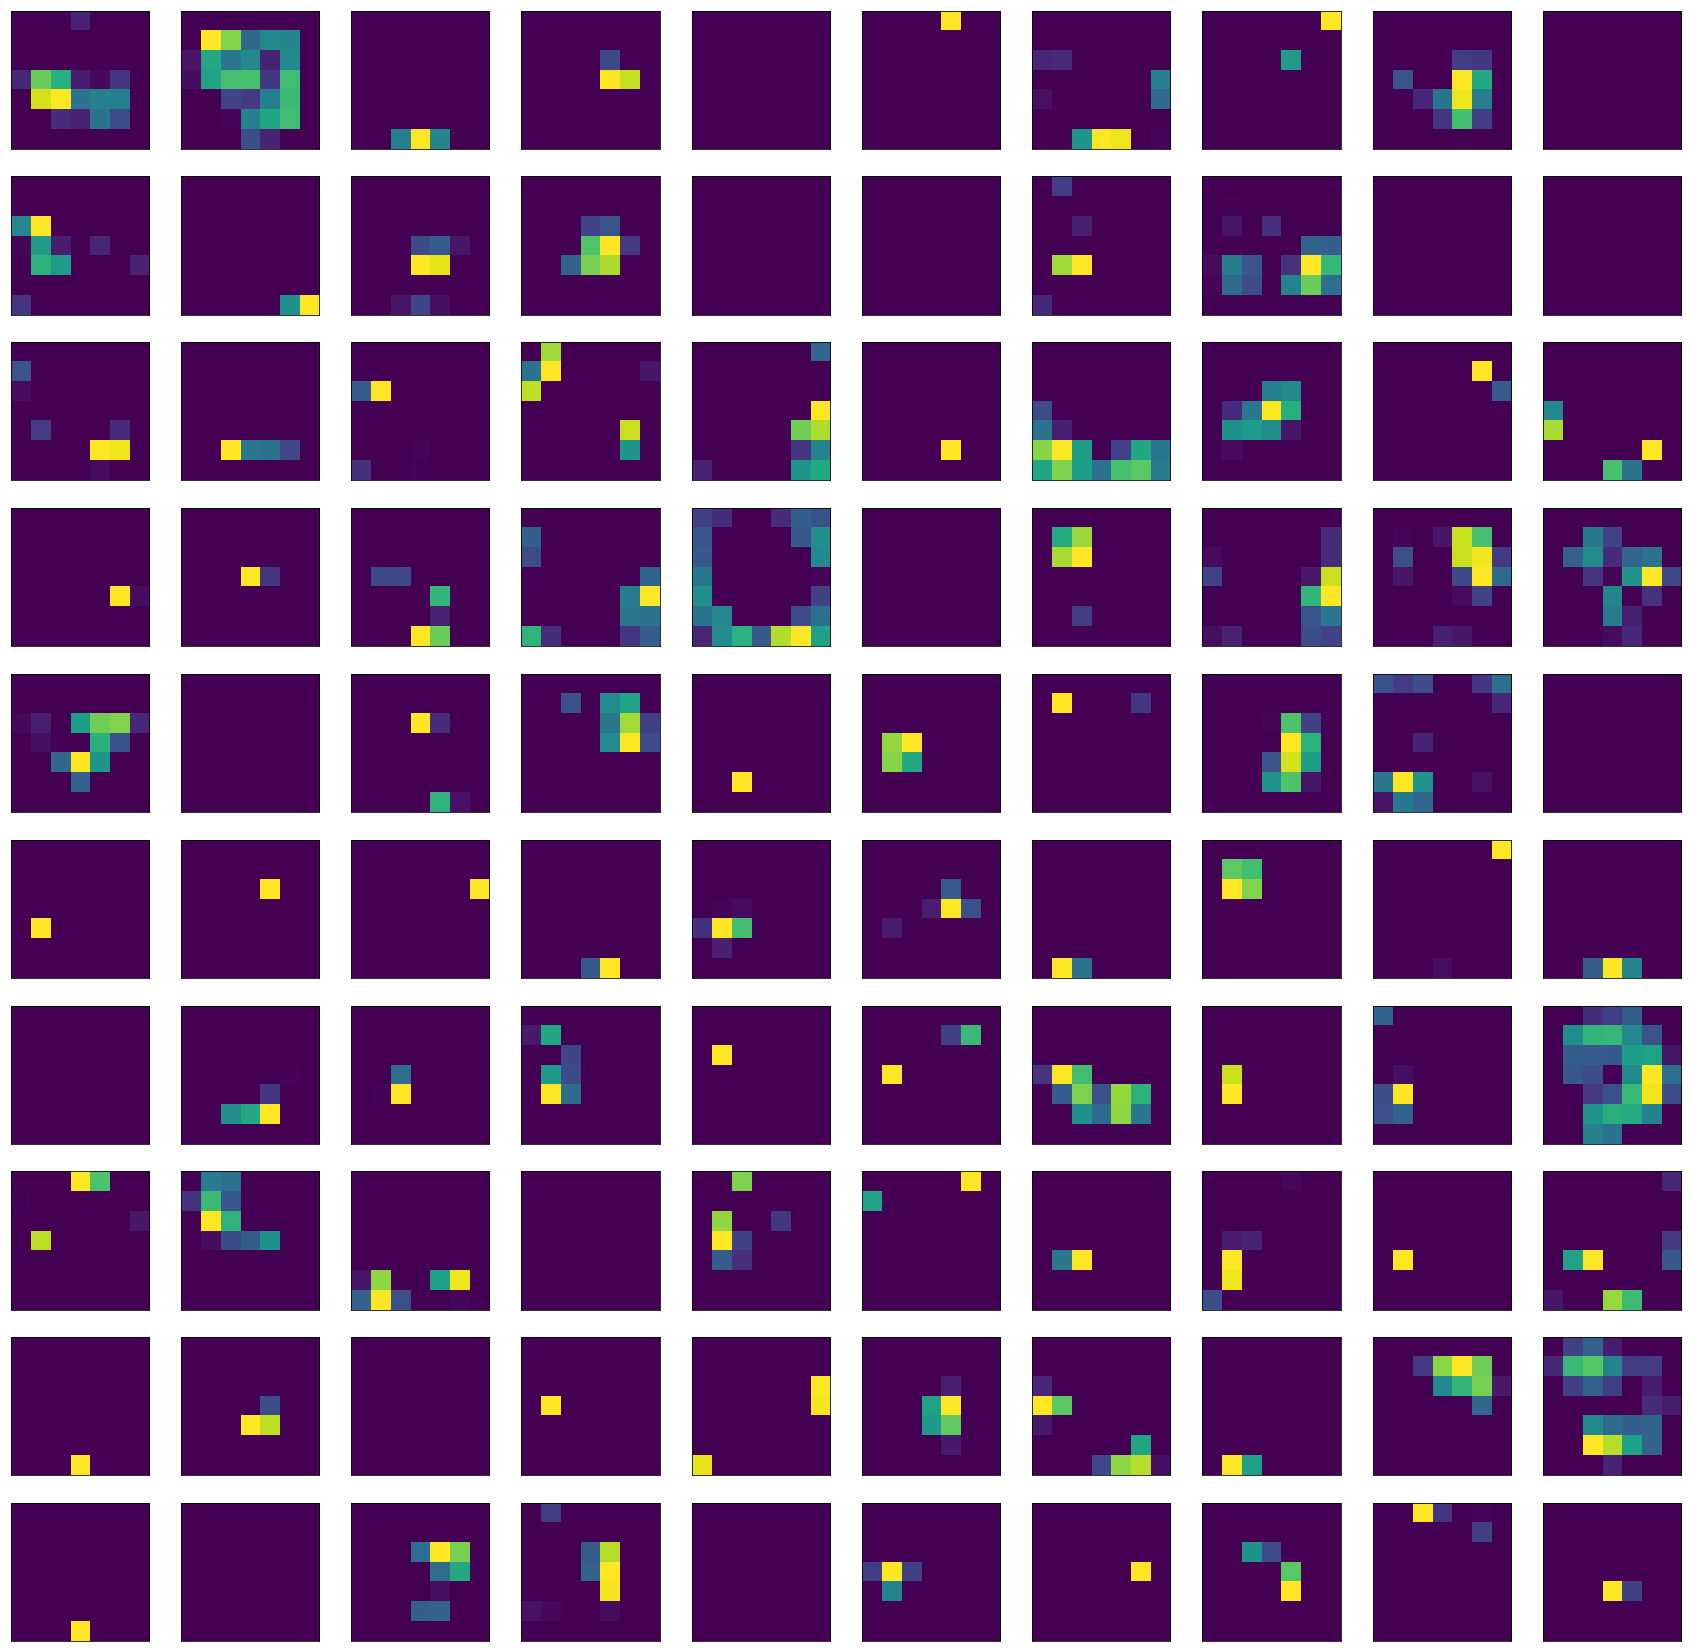

In [18]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(30,30))
for ax in axes.flat:
    # Hide all ticks and labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')
        
# Plot the data.
z = 0
for i, j in zip(*np.triu_indices_from(axes, k=0)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].imshow(temp5[5,:,:,z])
        z+=1